# <center>*EDA de Proyecto individual Parte 2*</center> #

In [805]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")

path="datasets/"

# Leyendo la tabla hechos #

In [806]:
nombres=["ID","n_victimas","fecha","year","mes","dia","hora_min","hora","lugar","tipo de calle","calle","altura","cruce","direccion_normalizada","comuna","XY(CABA)","x","y","participantes","victima","acusado"]
hechos=pd.read_excel(path+"homicidios.xlsx",sheet_name="HECHOS",names=nombres)

In [807]:
hechos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     696 non-null    object        
 1   n_victimas             696 non-null    int64         
 2   fecha                  696 non-null    datetime64[ns]
 3   year                   696 non-null    int64         
 4   mes                    696 non-null    int64         
 5   dia                    696 non-null    int64         
 6   hora_min               696 non-null    object        
 7   hora                   696 non-null    object        
 8   lugar                  696 non-null    object        
 9   tipo de calle          696 non-null    object        
 10  calle                  695 non-null    object        
 11  altura                 129 non-null    float64       
 12  cruce                  525 non-null    object        
 13  direc

Aqui se ven de una forma detallada y resumida los valores nulos en las siguientes columnas

In [808]:
porcentaje=pd.DataFrame(hechos.isna().mean()).reset_index()
porcentaje["columnas"]=porcentaje["index"]
porcentaje["porcentaje"]=porcentaje[0]
porcentaje.drop(columns=[0,"index"],inplace=True)

cantidad=pd.DataFrame(hechos.isna().sum().reset_index())
cantidad["cantidad"]=cantidad[0]
cantidad.drop(columns=[0],inplace=True)

nulos=pd.concat([porcentaje,cantidad["cantidad"]],axis=1)
nulos.drop(nulos[nulos["cantidad"]==0].index,inplace=True)
nulos

,columnas,porcentaje,cantidad
10,calle,0.001437,1
11,altura,0.814655,567
12,cruce,0.245690,171
13,direccion_normalizada,0.011494,8


Pero vemos que en la columna acusado esta el participante SD, que en el diccionario de datos especifica que significa Sin Datos

In [809]:
hechos[["participantes","victima","acusado"]][:5]

,participantes,victima,acusado
0,MOTO-AUTO,MOTO,AUTO
1,AUTO-PASAJEROS,AUTO,PASAJEROS
2,MOTO-AUTO,MOTO,AUTO
3,MOTO-SD,MOTO,SD
4,MOTO-PASAJEROS,MOTO,PASAJEROS


Estas son las columnas que tienen registros con "SD"

In [810]:
columnas=hechos.columns

def indigar(valor):
    try:
        if "SD" in valor:
            return True
        else:
            return False
    except:
        return False

for n in columnas:
    valor=hechos[n].apply(lambda x:indigar(x)).sum()
    if valor:
        print(n+" "*(20-len(n))+str(valor))

hora_min            1
hora                1
lugar               1
participantes       27
victima             9
acusado             23


Hay elementos en las columnas X e Y en donde solo hay un punto, lo cual es informacion que no sirve y se va a inputar valores nulos

In [811]:
mask=(hechos["x"]==".") & (hechos["y"]==".")
hechos[mask]["y"].count()

12

A continuacion vamos a analizar la columnas "n_victimas" (numero de victimas)

Y podemos concluir que puede llegar a haber de 1 a 3 victimas en un siniestro vial.

In [812]:
print(hechos["n_victimas"].mean())
print(hechos["n_victimas"].max())
print(hechos["n_victimas"].min())
print(hechos["n_victimas"].unique())

1.0301724137931034
3
1
[1 2 3]


En la siguiente tabla vemos que la gran mayoria de los casos solo hay una victima. aqui vemos que 3 es un outlier pero se tiene que apreciar con los graficos

In [813]:
vict=list(hechos["n_victimas"].unique())
cant=[]
for n in vict:
    cant.append(hechos[hechos["n_victimas"]==n]["n_victimas"].count())

pd.DataFrame({"n_victimas":vict,"cantidad":cant})

,n_victimas,cantidad
0,1,676
1,2,19
2,3,1


Aqui vemos que todos los 2 y el 3 son outliers, pues son el 2.95% de los datos

In [814]:
Q1 = hechos["n_victimas"].quantile(0.25)
Q3 = hechos["n_victimas"].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para identificar outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificar outliers
outliers = hechos[(hechos["n_victimas"] < limite_inferior) | (hechos["n_victimas"] > limite_superior)]

pd.set_option('display.max_rows', None)

# Imprimir los outliers
print("Número de outliers:", len(outliers))

Número de outliers: 20


En este diagrama se puede ver que 2 y 3 son outliers.

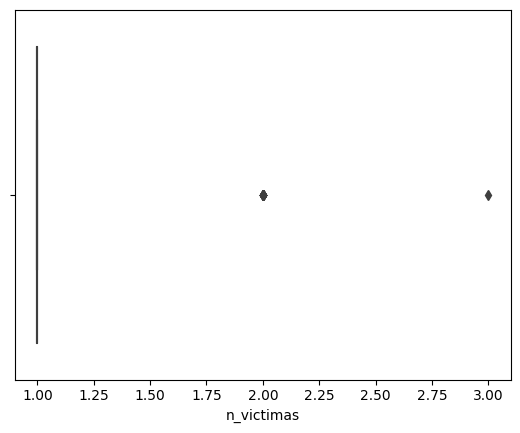

In [815]:
sns.boxplot(x=hechos["n_victimas"])
plt.show()

Aqui nos aseguramos que el campo comuna tenga valores de entre [1,15] pero vemos que hay valores con 0 cuando en el diccionario de datos dice que tiene valores del 1 al 15

In [816]:
print(hechos["comuna"].max())
print(hechos["comuna"].min())

15
0


por lo visto son solo 2 registros, por lo que podemos averiguar en que comuna estan 

En el primer registro hay nada de informacion util y en el segundo dice autopista:"25 de mayo" y al ser una autopista larga que esta incluida en gran parte del borde del area de la ciudad, es indeterminado saber en comuna ocurrio el accidente, cabe mencionar que falta informacion de su posicion con las coordenadas XY por lo que significa que estos 0 significan valores nulos

In [817]:
hechos[hechos["comuna"]==0][hechos.columns[8:18]]

,lugar,tipo de calle,calle,altura,cruce,direccion_normalizada,comuna,XY(CABA),x,y
119,SD,CALLE,NaN,NaN,NaN,NaN,0,Point (. .),.,.
139,AUTOPISTA 25 DE MAYO,AUTOPISTA,AUTOPISTA 25 DE MAYO,NaN,NaN,AUTOPISTA 25 DE MAYO,0,Point (. .),.,.


Aqui hacemos la inputacion de los nulos

In [818]:
hechos["comuna"].replace(0,np.nan,inplace=True)

En la tabla anterior tambien vimos que en los campos X e Y hay un '.' cuando no hay informacion, por que se podrian ver cuantos registros hay que les falten datos en esas columnas

Resultan ser 12 y siendo pocos podriamos ver si se pueden rescatar algunos datos

In [819]:
hechos[hechos["x"]=="."].shape[0]

12

Viendo los 12 no hay forma de completar la informacion, ninguno tiene altura, tampoco tienen una calle de interseccion

In [820]:
hechos[hechos["x"]=="."][hechos.columns[8:18]]

,lugar,tipo de calle,calle,altura,cruce,direccion_normalizada,comuna,XY(CABA),x,y
38,AUTOPISTA LUGONES PK 10000,AUTOPISTA,"LUGONES, LEOPOLDO AV.",NaN,NaN,NaN,13.0,Point (. .),.,.
106,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA,AUTOPISTA BUENOS AIRES - LA PLATA,NaN,NaN,NaN,4.0,Point (. .),.,.
119,SD,CALLE,NaN,NaN,NaN,NaN,NaN,Point (. .),.,.
139,AUTOPISTA 25 DE MAYO,AUTOPISTA,AUTOPISTA 25 DE MAYO,NaN,NaN,AUTOPISTA 25 DE MAYO,NaN,Point (. .),.,.
176,AV. LEOPOLDO LUGONES PKM 6900,GRAL PAZ,"LUGONES, LEOPOLDO AV.",NaN,NaN,"LUGONES, LEOPOLDO AV.",14.0,Point (. .),.,.
180,AU PERITO MORENO Y RAMAL ENLACE AU1/AU6,AUTOPISTA,AUTOPISTA PERITO MORENO,NaN,NaN,NaN,9.0,Point (. .),.,.
181,AU DELLEPIANE 2400,AUTOPISTA,AUTOPISTA DELLEPIANE LUIS TTE. GRAL.,NaN,NaN,NaN,7.0,Point (. .),.,.
256,AU ARTURO FRONDIZI PKM 3100,AUTOPISTA,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,NaN,NaN,AUTOPISTA 1 SUR PRESIDENTE ARTURO FRONDIZI,4.0,Point (. .),.,.
313,AUTOPISTA LUGONES KM 4.7,AUTOPISTA,"LUGONES, LEOPOLDO AV.",NaN,NaN,NaN,14.0,Point (. .),.,.
546,"LUGONES, LEOPOLDO AV. KM 6,1",AUTOPISTA,"LUGONES, LEOPOLDO AV.",NaN,NaN,NaN,14.0,Point (. .),.,.


Vamos a llevar a acabo algunos analisis y observaciones usando solamente los siguientes campos

In [821]:
analisis=hechos[["fecha","hora","n_victimas","participantes","victima","acusado"]]
analisis["year"]=analisis["fecha"].apply(lambda x:x.year)

En el siguiente grafico vemos la cantidad de accidentes que hubo por tipo de acusado, y vemos que los autos(vehiculos normales de civiles), cargas(que pueden ser camiones o camionetas) y pasajeros(que son los vehiculos de transporte publico, es decir, buses) son los que mas accidentes llevan, aunque tambien hay una cantidad considerable de moto y objeto fijo

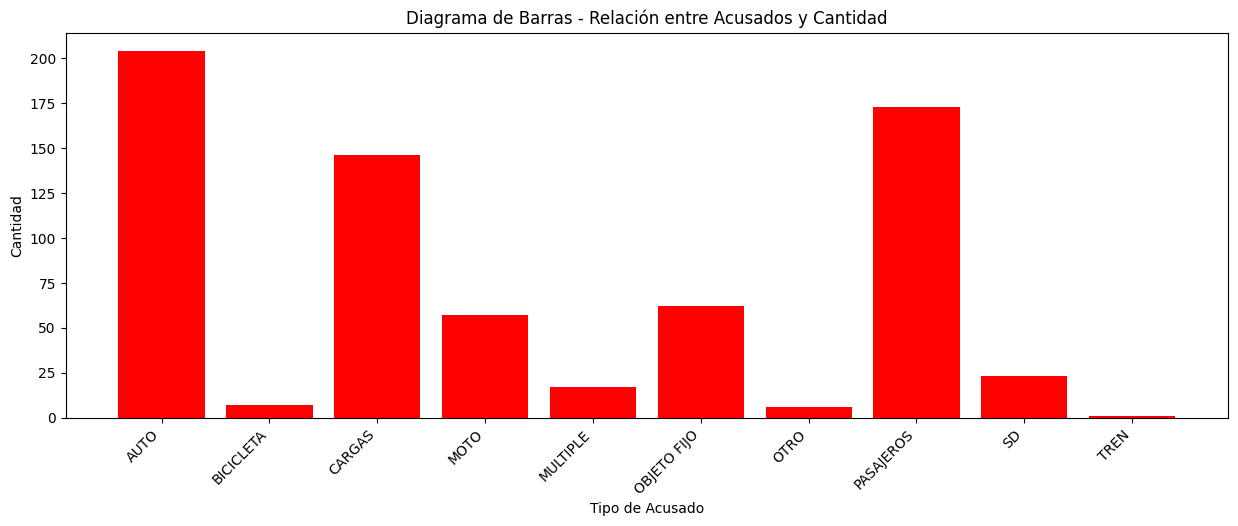

In [822]:
dicc=dict(analisis[["acusado"]].groupby("acusado").agg({"acusado":"count"})["acusado"])
acusados=pd.DataFrame({"acusado":list(dicc.keys()),"cantidad":[dicc[n] for n in dicc]})

plt.figure(figsize=(15, 5))  # Ajusta el tamaño de la figura según tus necesidades
plt.bar(acusados['acusado'], acusados['cantidad'], color='Red')
plt.xticks(rotation=45, ha='right')
plt.title('Diagrama de Barras - Relación entre Acusados y Cantidad')
plt.xlabel('Tipo de Acusado')
plt.ylabel('Cantidad')
plt.show()

Aqui vemos que los tipos de victimas son moto y peatones, es razonable ya que son mas vulnerables y en los siniestros viales, pero vemos que hay mas victimas de moto que de peatones. Por que? Los motorizados van mucho mas rapido, eso es un factor de riesgo extra ya que cualquier caida puede ser fatal, sin mencionar que se mueven en las vias de transito esto hace mas probable que las motos puedan ser en su mayoria mas victimas que en el caso de los peatones

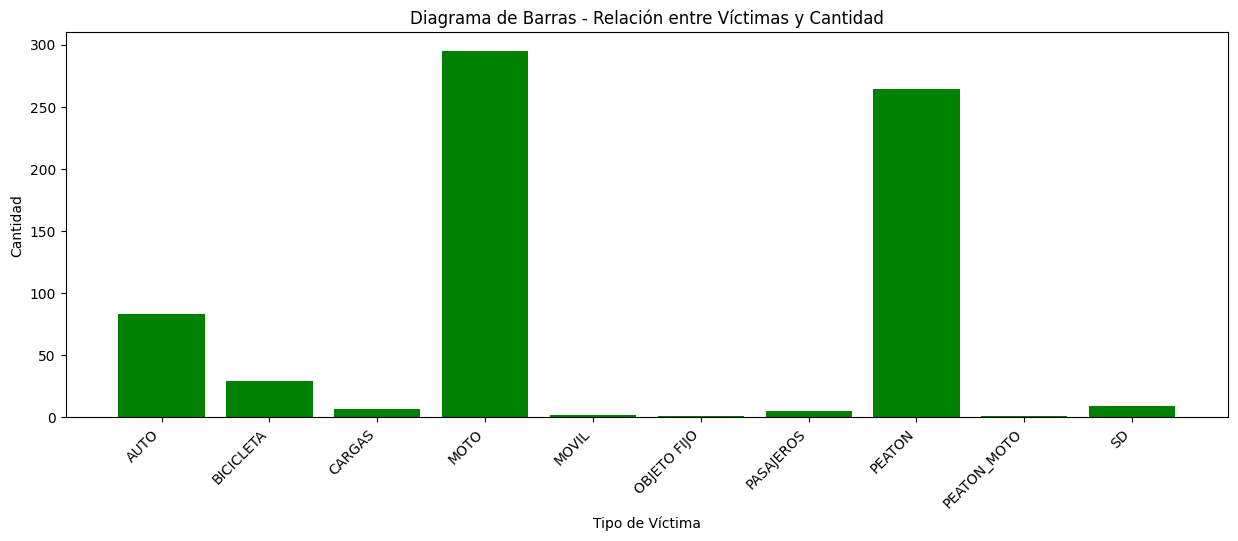

In [823]:
dicc=dict(analisis[["victima"]].groupby("victima").agg({"victima":"count"})["victima"])
victimas=pd.DataFrame({"victimas":list(dicc.keys()),"cantidad":[dicc[n] for n in dicc]})

plt.figure(figsize=(15, 5))  # Ajusta el tamaño de la figura según tus necesidades
plt.bar(victimas['victimas'], victimas['cantidad'], color='green')
plt.xticks(rotation=45, ha='right')
plt.title('Diagrama de Barras - Relación entre Víctimas y Cantidad')
plt.xlabel('Tipo de Víctima')
plt.ylabel('Cantidad')
plt.show()

In [824]:
mask=hechos["participantes"].apply(lambda x:"tren" in x.lower())
hechos[mask]

,ID,n_victimas,fecha,year,mes,dia,hora_min,hora,lugar,tipo de calle,...,altura,cruce,direccion_normalizada,comuna,XY(CABA),x,y,participantes,victima,acusado
501,2019-0085,1,2019-10-09,2019,10,9,22:18:00,22,CARDOSO Y BACACAY,CALLE,...,NaN,BACACAY,CARDOSO y BACACAY,10.0,Point (97311.79828581 99453.65686299),-58.49261744,-34.63419130,BICICLETA-TREN,BICICLETA,TREN


Me di cuenta que hay un error en la tabla, y es que en el campo "tipo de calle" esta incluido "GRAL PAZ" que es una autopista

In [825]:
hechos["tipo de calle"].unique()

array(['AVENIDA', 'GRAL PAZ', 'CALLE', 'AUTOPISTA'], dtype=object)

Vemos que aparecen 65 veces lo cual es mucho y muy raro

In [826]:
mask=hechos["tipo de calle"]=="GRAL PAZ"
hechos[mask]["tipo de calle"].count()

65

Le inputamos "AUTOPISTA" ya que la general paz es una autopista

In [827]:
hechos["tipo de calle"].replace("GRAL PAZ","AUTOPISTA",inplace=True)

Se va a hacer un breve analisis de cuantos siniestros por comuna hubo entre el 2016-2021.
En una comuna pueden estar incluido 1 o mas barrios(localidades) 

In [828]:
comunas=hechos.groupby("comuna").agg({"comuna":"count"})
comunas["cantidad"]=comunas["comuna"]
comunas.drop(columns=["comuna"],inplace=True)
comunas.reset_index(inplace=True)
comunas["comuna"]=comunas["comuna"].apply(lambda x:int(x))

La comuna uno es la que mas accidentes ha tenido en ese tiempo, y abarca los barrios Retiro, San Nicolás, Puerto Madero, San Telmo, Monserrat y Constitución, al ser una de las comunas mas grandes el transito es muy elevado, teniendo edificios publicos y administrativos, avenidas principales y zonas turisticas que hacen que en esta parte de la ciudad haya mas probabilidad de haber un accidente de transito debido a la alta circulacion.

[fuente](https://www.lanacion.com.ar/buenos-aires/ciudad-cuales-son-los-barrios-donde-hay-mas-muertes-por-accidentes-de-transito-nid20052021/)

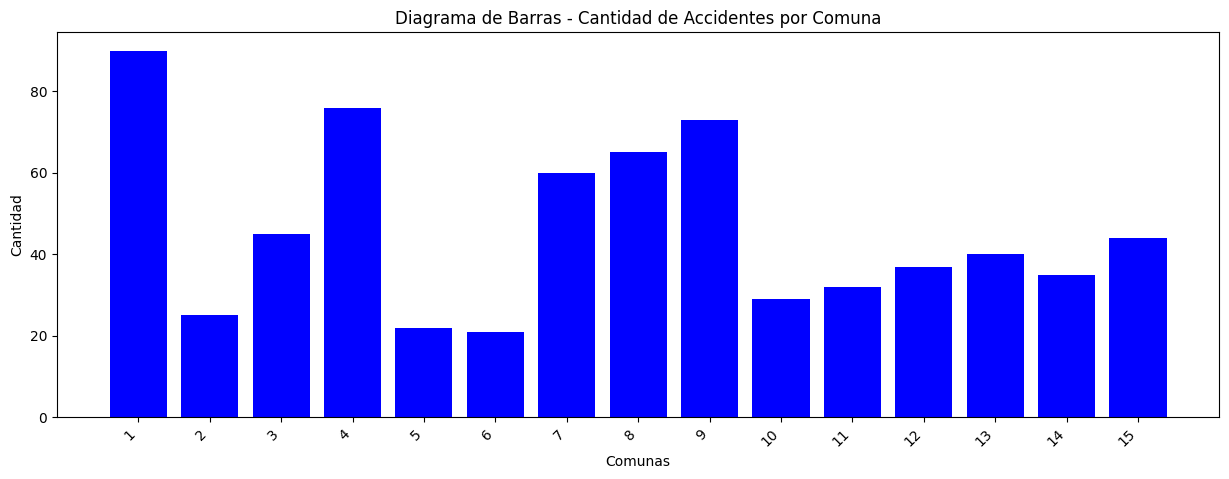

In [829]:
plt.figure(figsize=(15, 5))
plt.bar(comunas['comuna'], comunas['cantidad'], color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Diagrama de Barras - Cantidad de Accidentes por Comuna')
plt.xlabel('Comunas')
plt.ylabel('Cantidad')
plt.xticks(comunas['comuna'])
plt.show()

A continuacion un analisis de la cantidad de accidentes por tipo de calle

In [830]:
calles=hechos.groupby("tipo de calle").agg({"tipo de calle":"count"})
calles["cantidad"]=calles["tipo de calle"]
calles.drop(columns=["tipo de calle"],inplace=True)
calles.reset_index(inplace=True)

Parece que es mas comun los accidentes en las avenidas y con diferecia, siendo las calles y autopistas similares, pero Por que?
Bueno, una explicacion logica puede ser que si bien en las autopistas suelen haber muchos vehiculos y con velocidades mas altas,la accesibilidad es minima es decir que no hay tantos accesos como en una avenida o en una calle, y en las calles hay menos trafico que en las avenidas, teniendo en cuenta que son mas angostas y las avenidas son mas abiertas y teniendo la misma cantidad de accesos que las calles siempre tienen mas transito por lo que es razonable que la mayoria de accidentes ocurran en avenidas.

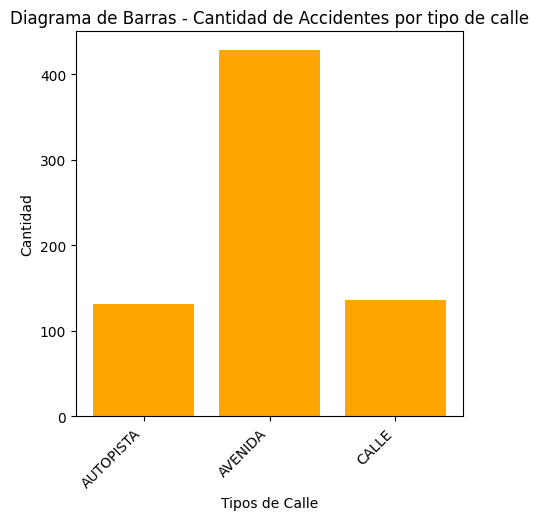

In [831]:
plt.figure(figsize=(5, 5))
plt.bar(calles['tipo de calle'], calles['cantidad'], color='orange')
plt.xticks(rotation=45, ha='right')
plt.title('Diagrama de Barras - Cantidad de Accidentes por tipo de calle')
plt.xlabel('Tipos de Calle')
plt.ylabel('Cantidad')
plt.show()

Por ultimo se hara una observacion a los accidentes por la hora del dia

La muestra de estos datos es pequeña y vemos que es muy aleatorio, no se puede analizar mucho mas que en las horas en las que hay mas actividad son en las horas donde es de dia o es un horario en el que hay actividad.

In [832]:
hora=hechos.groupby("hora").agg({"hora":"count"})
hora["cantidad"]=hora["hora"]
hora.drop(columns=["hora"],inplace=True)
hora.reset_index(inplace=True)
hora.sort_values(by="cantidad",ascending=False)

,hora,cantidad
7,7,41
6,6,40
9,9,36
5,5,35
14,14,33
12,12,32
8,8,31
18,18,31
10,10,31
22,22,30


Hay muchas cosas que deben ser analizadas, pero eso se hara en los dashboards interactivos

# Leyendo la tabla victimas #

In [833]:
nombres=["ID","fecha","year","mes","dia","rol","victima","sexo","edad","fecha_fallecimiento"]
victimas=pd.read_excel(path+"homicidios.xlsx",sheet_name="VICTIMAS",names=nombres)

In [834]:
victimas[:10]

,ID,fecha,year,mes,dia,rol,victima,sexo,edad,fecha_fallecimiento
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03 00:00:00
3,2016-0004,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,SD
4,2016-0005,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01 00:00:00
5,2016-0008,2016-01-24,2016,1,24,CONDUCTOR,MOTO,MASCULINO,30,2016-01-24 00:00:00
6,2016-0009,2016-01-24,2016,1,24,PASAJERO_ACOMPAÑANTE,MOTO,MASCULINO,29,2016-01-26 00:00:00
7,2016-0010,2016-01-29,2016,1,29,CONDUCTOR,MOTO,MASCULINO,18,2016-01-29 00:00:00
8,2016-0012,2016-02-08,2016,2,8,CONDUCTOR,MOTO,MASCULINO,22,2016-02-08 00:00:00
9,2016-0013,2016-02-10,2016,2,10,PEATON,PEATON,MASCULINO,16,2016-02-10 00:00:00


In [835]:
victimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   717 non-null    object        
 1   fecha                717 non-null    datetime64[ns]
 2   year                 717 non-null    int64         
 3   mes                  717 non-null    int64         
 4   dia                  717 non-null    int64         
 5   rol                  717 non-null    object        
 6   victima              717 non-null    object        
 7   sexo                 717 non-null    object        
 8   edad                 717 non-null    object        
 9   fecha_fallecimiento  717 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 56.1+ KB


No hay ningun dato faltante (hablando especificamente de nulos)

In [836]:
victimas.isna().sum()

ID                     0
fecha                  0
year                   0
mes                    0
dia                    0
rol                    0
victima                0
sexo                   0
edad                   0
fecha_fallecimiento    0
dtype: int64

A continuacion se muestran a cantidad de valores faltantes que hay en cada columna basado en el valor "SD" que significa Sin Dato

In [837]:
def ver_nulos(valor):
    try:
        return "SD" in valor
    except:
        return False

for n in victimas.columns:
    print(n+" "*(25-len(n))+str(victimas[n].apply(lambda x:ver_nulos(x)).sum()))


ID                       0
fecha                    0
year                     0
mes                      0
dia                      0
rol                      11
victima                  9
sexo                     6
edad                     53
fecha_fallecimiento      68


Vamos hacer algunos graficos y tablas para observar las estadisticas de las victimas

In [838]:
analisis=victimas[["rol","victima","sexo","edad","fecha_fallecimiento"]]

for n in analisis.columns[:-1]:
    print(analisis[n].unique())

['CONDUCTOR' 'PASAJERO_ACOMPAÑANTE' 'PEATON' 'SD' 'CICLISTA']
['MOTO' 'AUTO' 'PEATON' 'SD' 'CARGAS' 'BICICLETA' 'PASAJEROS' 'MOVIL']
['MASCULINO' 'FEMENINO' 'SD']
[19 70 30 18 29 22 16 59 65 34 41 50 38 21 52 36 20 54 'SD' 56 24 78 79 26
 57 37 58 23 60 42 53 51 40 87 76 75 35 80 43 45 67 27 55 49 81 25 33 46
 83 39 28 7 48 4 82 32 17 47 61 10 95 73 84 66 85 1 15 13 77 44 31 62 74
 71 11 86 69 72 12 63 92 68 91 64 5 88]


In [839]:
tab=analisis[["rol"]].groupby("rol").agg({"rol":"count"})
tab["cantidad"]=tab["rol"]
tab.drop(columns=["rol"],inplace=True)
tab.reset_index(inplace=True)
tab

,rol,cantidad
0,CICLISTA,29
1,CONDUCTOR,330
2,PASAJERO_ACOMPAÑANTE,80
3,PEATON,267
4,SD,11


Esta informacion coincide con la tabla hechos, ya que vimos anteriormente que la mayoria accidentes las victima son conductores en moto.

El rol CONDUCTOR no solo son conductores de moto tambien hay de autos, cargas y moviles(que son carros policiales, ambulancias o bomberos)

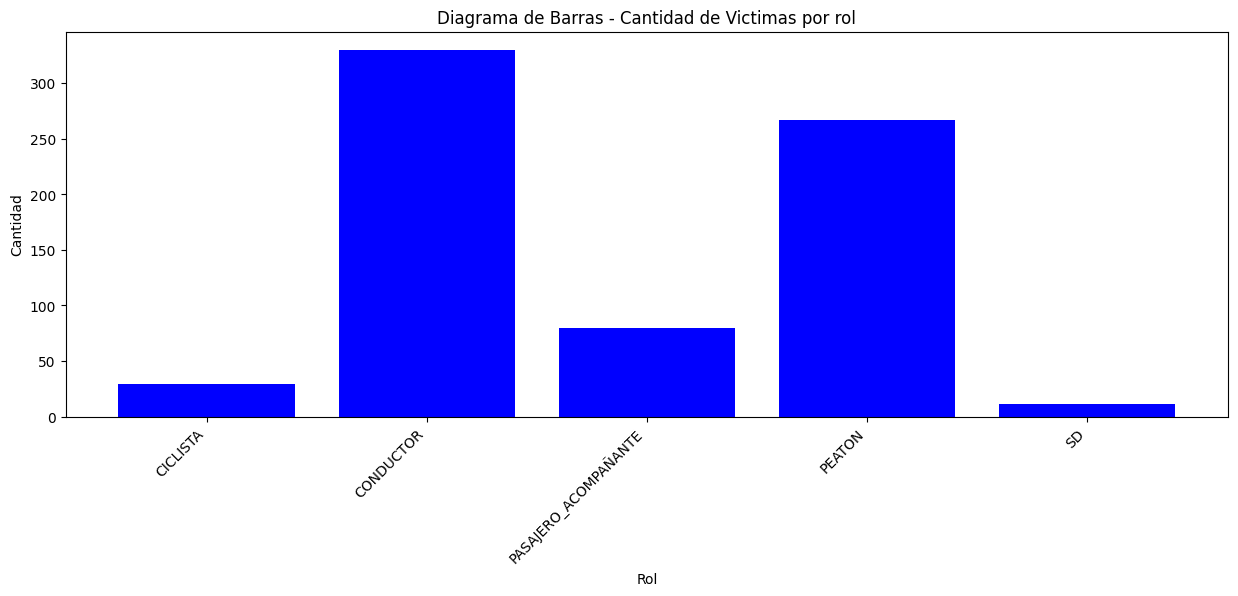

In [840]:
plt.figure(figsize=(15, 5))
plt.bar(tab['rol'], tab['cantidad'], color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Diagrama de Barras - Cantidad de Victimas por rol')
plt.xlabel('Rol')
plt.ylabel('Cantidad')
plt.xticks(tab['rol'])
plt.show()

Vamos a ver que tipo de vehiculos hay en el rol conductor

In [841]:
mask=analisis["rol"]=="CONDUCTOR"
tab=analisis[mask][["victima"]].groupby("victima").agg({"victima":"count"})
tab["cantidad"]=tab["victima"]
tab.drop(columns=["victima"],inplace=True)
tab.reset_index(inplace=True)
tab

,victima,cantidad
0,AUTO,65
1,CARGAS,3
2,MOTO,261
3,MOVIL,1


La tabla que se acaba de imprimir demuestra que la mayoria de las victimas son conductoras de moto, un 79.1% precisamente segun esta tabla.

Tiene que ver con la cantidad de motorizados que hay y la vulnerabilidad que tienen en un accidente, los autos tambien son muchos pero son mas seguros que las motos en una colision 

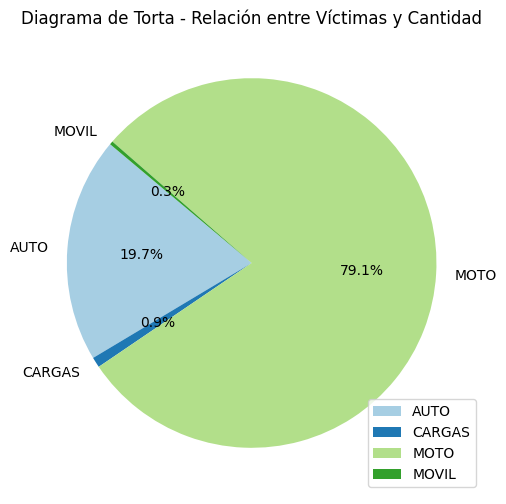

In [842]:
colores = plt.cm.Paired(range(len(tab)))

plt.figure(figsize=(6, 6))  # Ajusta el tamaño de la figura según tus necesidades
plt.pie(tab['cantidad'], labels=tab['victima'], autopct='%1.1f%%', startangle=140, colors=colores)
plt.legend(loc='lower right')
plt.title('Diagrama de Torta - Relación entre Víctimas y Cantidad')
plt.show()

Analizando las edades de las victimas

In [843]:
intervalos=range(1,101,10)
mask=analisis["edad"]!="SD"
tab=analisis[mask][["edad"]]
tab["edad"]=tab["edad"].apply(lambda x:int(x))
tab["intervalo"]=pd.cut(tab["edad"],bins=intervalos,right=False)
tab=tab.groupby("intervalo").agg({'edad':"sum"})
tab.reset_index(inplace=True)
tab

,intervalo,edad
0,"[1, 11)",42
1,"[11, 21)",867
2,"[21, 31)",5000
3,"[31, 41)",4578
4,"[41, 51)",3829
5,"[51, 61)",4348
6,"[61, 71)",2382
7,"[71, 81)",4399
8,"[81, 91)",2185


La unica interpretacion que le puedo dar al siguiente grafico en el intervalo [1,11), son niños que estan en el auto y la logica me dice que las personas que llevan niños en el auto suelen ser mas seguros conduciendo, en el intervalo [11,21) entendemos que sea mas alta ya que los jovenes pueden empezar a manejar desde los 17 anios en moto o en auto pero ese analisis se puede hacer mejor con los dashboards interactivos 

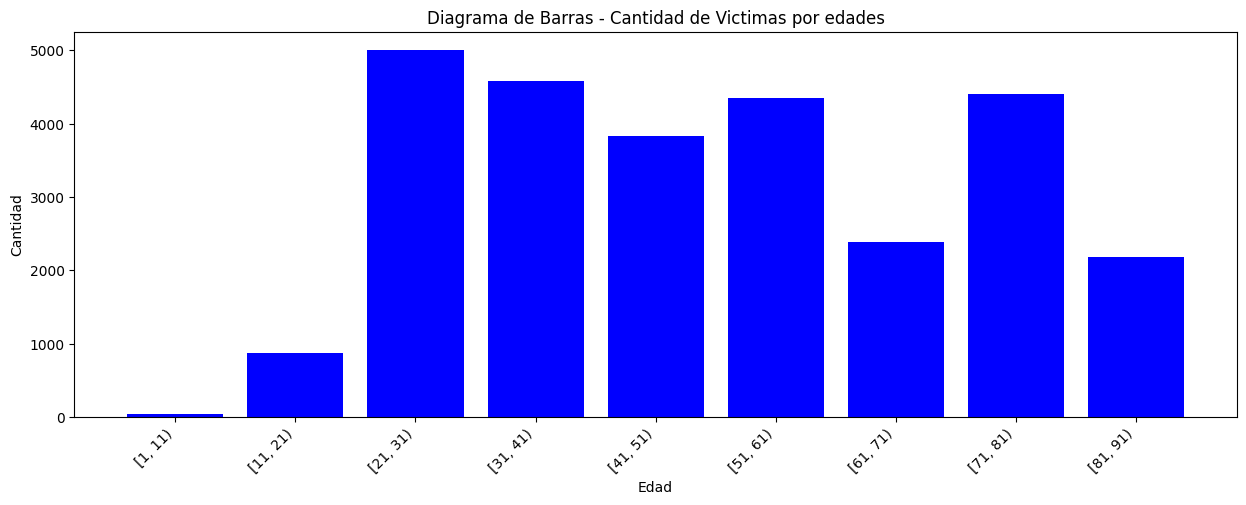

In [844]:
tab["intervalo"]=tab["intervalo"].apply(lambda x:str(x))
plt.figure(figsize=(15, 5))
plt.bar(tab['intervalo'], tab['edad'], color='blue')
plt.xticks(rotation=45, ha='right')
plt.title('Diagrama de Barras - Cantidad de Victimas por edades')
plt.xlabel('Edad')
plt.ylabel('Cantidad')
plt.xticks(tab['intervalo'])
plt.show()

Para sacarnos las dudas, la siguiente tabla muestra las victimas con edades de [11,21) años y que su rol es de CONDUCTOR,
se puede ver en la tabla que todos son conductores de moto y que tienen de 17 a 20 años de edad

In [845]:
tab=analisis[["rol","victima","edad"]]
mask= analisis["edad"]!="SD"
tab= tab[mask]
tab["edad"]=tab["edad"].apply(lambda x:int(x))

mask= (tab["edad"]>10) & (tab["edad"]<21) & (tab["rol"]=="CONDUCTOR")
tab[mask].sort_values(by="edad")

,rol,victima,edad
472,CONDUCTOR,MOTO,17
370,CONDUCTOR,MOTO,17
181,CONDUCTOR,MOTO,17
3,CONDUCTOR,MOTO,18
7,CONDUCTOR,MOTO,18
146,CONDUCTOR,MOTO,18
536,CONDUCTOR,MOTO,18
0,CONDUCTOR,MOTO,19
294,CONDUCTOR,MOTO,19
207,CONDUCTOR,MOTO,19


Viendo la cantidad de victimas por sexo, se puede apreciar que con gran diferencia el sexo masculino supera al femenino, Por que?.
Aunque hay mas mucho mas varones que mujeres que conducen, lo cierto es que las muejeres suelen ser mas precavidas manejando y respetando las normas de transito, en diferentes estudios estadisticos y fuentes de informacion se argumenta esto mismo.

[Fuente de clarin](https://www.clarin.com/autos/volante-mujeres-seguras-hombres_0_xbP3c8B40H.html) 

In [846]:
tab=analisis[["sexo"]].groupby("sexo").agg({"sexo":"count"})
tab["cantidad"]=tab["sexo"]
tab.drop(columns=["sexo"],inplace=True)
tab.reset_index(inplace=True)
tab

,sexo,cantidad
0,FEMENINO,166
1,MASCULINO,545
2,SD,6


Dado por finalizado el EDA se haran unos pequeños ajustes para luego hacer los dashboards en power bi

A continuacion vamos a llenar son "SD" los valores nulos

In [847]:
hechos["x"].replace(".",np.nan,inplace=True)
hechos["y"].replace(".",np.nan,inplace=True)

hechos["x"].replace("SD",np.nan,inplace=True)
hechos["y"].replace("SD",np.nan,inplace=True)

hechos["x"]=hechos["x"].apply(lambda x:float(x))
hechos["y"]=hechos["y"].apply(lambda x:float(x))

victimas.fillna("SD",inplace=True)

In [848]:
mask=~hechos["direccion_normalizada"].isna()
hechos.loc[mask,"direccion_normalizada"]=hechos[mask]["direccion_normalizada"].apply(lambda x:x+", CABA")
#hechos["direccion_normalizada"]=hechos["direccion_normalizada"].apply(lambda x:x+", CABA")

In [849]:
mask=~hechos["comuna"].isna()
hechos.loc[mask,"comuna"]=hechos[mask]["comuna"].apply(lambda x:"Comuna "+str(int(x)))

In [850]:
mask=~hechos["lugar"].isna()
print(hechos[mask]["lugar"].apply(lambda x:"\n" in x).sum())
hechos.loc[mask,"lugar"]=hechos[mask]["lugar"].apply(lambda x:x.strip("\n"))

1


Hubo un problema en power bi, y es que en los valores nulos de X e Y por defecto coloca 0 y 0 a los valores nulos,el lugar de estas coordenadas es en el atlantico cerca de africa, pero el porblema es que cuando se van a aplicar los filtros de las comunas no se pueden apreciar bien en uno de los mapas ya que se expande para poder mostrar tambien dicho punto y como se ve a continuacion estos valores nulos representan el 1,72% de los datos, por lo que no cambia mucho si se borran o no, para poder llevar la visualizacion del dashboard adelante.

In [851]:
hechos[["x","y"]].isna().mean()

x    0.017241
y    0.017241
dtype: float64

In [852]:
hechos.dropna(subset=["x","y"],inplace=True)

Aqui hay un error y es que hay como una fecha mal puesta antes que la hora y sera modificado para que siga el formato de los demas elementos del campo

In [853]:
mask=hechos["hora_min"].apply(lambda x:len(str(x))!=8)
hechos[mask][["hora_min"]]

,hora_min
439,1900-01-02 00:00:00
441,1900-01-14 07:12:00
496,1900-01-04 18:40:00
518,SD


In [854]:
mask= mask & (hechos["hora_min"]!="SD")
hechos.loc[mask,"hora_min"]=hechos[mask]["hora_min"].apply(lambda x:str(x).split(" ")[1])
hechos["hora_min"].replace("SD",np.nan,inplace=True)

In [855]:
hechos["hora"].replace("SD",np.nan,inplace=True)

Este diccionario se realiza para poder graficar las areas de comunas en el mapa, el navegador del mapa no reconoce todas las comunas por su nombre, pero los barrios si, asi que con este diccionario se puede armar una tabla de los barrios y su comuna 

In [856]:
comunas_barrios = {
    "Comuna 1": "Retiro, San Nicolás, San Telmo, Monserrat, Constitución,Puerto Madero",
    "Comuna 2": "Recoleta",
    "Comuna 3": "Balvanera, San Cristóbal",
    "Comuna 4": "La Boca, Barracas, Parque Patricios, Nueva Pompeya",
    "Comuna 5": "Almagro, Boedo",
    "Comuna 6": "Caballito",
    "Comuna 7": "Flores, Parque Chacabuco",
    "Comuna 8": "Villa Soldati, Villa Riachuelo, Villa Lugano",
    "Comuna 9": "Liniers, Mataderos,Parque Avellaneda",
    "Comuna 10": "Villa Real, Monte Castro, Versalles, Floresta,Villa Luro, Velez Sarsfield",
    "Comuna 11": "Villa General Mitre, Villa Devoto, Villa del Parque, Villa Santa Rita",
    "Comuna 12": "Coghlan, Saavedra, Villa Urquiza,Villa Pueyrredon",
    "Comuna 13": "Belgrano, Colegiales,Nuñez",
    "Comuna 14": "Palermo",
    "Comuna 15": "Chacarita, Villa Crespo, La Paternal, Villa Ortúzar, Agronomia, Parque chas"
}

mask=~hechos["comuna"].isna()
hechos["barrio"]=hechos["comuna"]
hechos.loc[mask,"barrio"]=hechos[mask]["barrio"].apply(lambda x:comunas_barrios[x.rstrip(", CABA")]+", CABA")
#hechos["barrio"]

In [857]:
dicc={"barrios":[],"comuna":[]}
for elemento in list(comunas_barrios.keys()):
    for n in comunas_barrios[elemento].split(","):
        dicc["barrios"].append(n.strip()+", CABA")
        dicc["comuna"].append(elemento)

barrios=pd.DataFrame(dicc)

In [858]:
victimas["edad"].replace("SD",np.nan,inplace=True)
victimas["edad"].isna().sum()

53

Viendo cuantos valores sin dato hay en el campo hora

In [859]:
hechos["hora"].apply(lambda x:x=="SD").sum()

0

Lo mismo pero con el campo victima

In [860]:
hechos[hechos["victima"].apply(lambda x:x=="SD")]["victima"].count()

8

In [861]:
hechos["victima"].replace("SD",np.nan,inplace=True)

Se establece el semestre como campo para poder hacer mejor los calculos

In [862]:
def establecer_semestre(mes):
    if mes<7:
        return 1
    else:
        return 2
    
hechos["semestre"]=hechos["fecha"].apply(lambda x:establecer_semestre(x.month))

In [863]:
hechos.columns

Index(['ID', 'n_victimas', 'fecha', 'year', 'mes', 'dia', 'hora_min', 'hora',
       'lugar', 'tipo de calle', 'calle', 'altura', 'cruce',
       'direccion_normalizada', 'comuna', 'XY(CABA)', 'x', 'y',
       'participantes', 'victima', 'acusado', 'barrio', 'semestre'],
      dtype='object')

In [864]:
accidentes_semestral=hechos[["ID","year","semestre"]].groupby(["year","semestre"]).agg({"ID":"count"}).reset_index()
accidentes_semestral["cantidad"]=accidentes_semestral["ID"]
accidentes_semestral.drop(columns=["ID"],inplace=True)

La creacion de este campo es para que el kpi de power bi pueda graficar los valores por semestre.

In [865]:
def fecha_semestre(fecha:str):
    year=fecha.split("-")[0]
    mes=fecha.split("-")[1]

    if int(mes)<7:
        return year+"-"+"06-30"
    else:
        return year+"-"+"12-31"

hechos["fecha_semestre"]=hechos["fecha"].apply(lambda x:fecha_semestre(str(x)))

Para sacar el kpi de la tasa de mortalidad se acude a un dataset que tiene informacion de la poblacion total por comuna medida con el censo

[link del dataset](https://www.estadisticaciudad.gob.ar/eyc/?p=76599) 

In [866]:
file=pd.ExcelFile(path+"PDE.xlsx")
nombres=file.sheet_names
file.close()

years=nombres[2:8][::-1]

dicc={"comuna":[],"anio":[],"poblacion":[]}


for n in years:
    df=pd.read_excel(path+"PDE.xlsx",sheet_name=n,nrows=19,skiprows=2)
    df["anios"]=n
    df["comuna"]=df[df.columns[0]]
    df=df[["comuna","Total","anios"]]
    try:
        df.drop([0,16,17],inplace=True)
    except:
        pass

    dicc["comuna"].extend(list(df["comuna"]))
    dicc["anio"].extend(list(df["anios"]))
    dicc["poblacion"].extend(list(df["Total"]))

poblacion=pd.DataFrame(dicc)

poblacion["comuna"]=poblacion["comuna"].apply(lambda x:"Comuna "+str(x))
poblacion["fecha"]=poblacion["anio"].apply(lambda x:"31/12/"+str(x))
poblacion["year"]=poblacion["anio"].apply(lambda x:int(x))
poblacion.drop(columns=["anio"],inplace=True)

poblacion.to_csv(path+"poblacion.csv")

In [867]:
total=poblacion.groupby("year").agg({"poblacion":"sum"}).reset_index()
total["poblacion_total"]=total["poblacion"]
total.drop(columns=["poblacion"],inplace=True)
total

,year,poblacion_total
0,2016,3059122.0
1,2017,3063728.0
2,2018,3068043.0
3,2019,3072029.0
4,2020,3075646.0
5,2021,3078836.0


Las siguientes celdas de codigo tienen como objetivo crear una tabla para cada kpi donde contenga un campo sea el valor por comuna y otro general y los dos con su respectivo objetivo, en este proceso se crean varias tablas y contantemente se hacen visualizaciones

In [868]:
tabla=pd.merge(poblacion,hechos,on=["comuna","year"],how="right")
tabla=tabla[["comuna","year","fecha_semestre","poblacion","semestre"]]
tabla.sort_values(by=["comuna","year"],inplace=True)
tabla['tasa_comunal'] = (tabla.groupby(['comuna','year','semestre'])['poblacion'].transform(lambda x: (x.count() / x) * 100000))

tabla[:15]


,comuna,year,fecha_semestre,poblacion,semestre,tasa_comunal
2,Comuna 1,2016,2016-06-30,252053.0,1,4.760903
4,Comuna 1,2016,2016-06-30,252053.0,1,4.760903
8,Comuna 1,2016,2016-06-30,252053.0,1,4.760903
9,Comuna 1,2016,2016-06-30,252053.0,1,4.760903
14,Comuna 1,2016,2016-06-30,252053.0,1,4.760903
16,Comuna 1,2016,2016-06-30,252053.0,1,4.760903
20,Comuna 1,2016,2016-06-30,252053.0,1,4.760903
33,Comuna 1,2016,2016-06-30,252053.0,1,4.760903
42,Comuna 1,2016,2016-06-30,252053.0,1,4.760903
43,Comuna 1,2016,2016-06-30,252053.0,1,4.760903


In [869]:
kpi_comunal=tabla[["comuna","year","semestre","tasa_comunal"]].drop_duplicates()
kpi_comunal["objetivo_comunal"]=np.nan

comunas=list(kpi_comunal["comuna"].unique())

for n in comunas:
    mask=kpi_comunal["comuna"]==n
    kpi_comunal.loc[mask,"objetivo_comunal"]=kpi_comunal[mask]["tasa_comunal"].shift()*0.9

kpi_comunal.reset_index(inplace=True)
kpi_comunal.drop(columns=["index"],inplace=True)

kpi_comunal[:15]

,comuna,year,semestre,tasa_comunal,objetivo_comunal
0,Comuna 1,2016,1,4.760903,NaN
1,Comuna 1,2016,2,3.967420,4.284813
2,Comuna 1,2017,1,4.343174,3.570678
3,Comuna 1,2017,2,2.763838,3.908857
4,Comuna 1,2018,1,3.144555,2.487454
5,Comuna 1,2018,2,4.323763,2.830100
6,Comuna 1,2019,1,3.523098,3.891387
7,Comuna 1,2019,2,1.174366,3.170788
8,Comuna 1,2020,1,1.950040,1.056929
9,Comuna 1,2020,2,1.950040,1.755036


In [870]:
tabla=pd.merge(tabla,kpi_comunal,on=["comuna","year","semestre"],how="left").drop(columns=["tasa_comunal_y"])
tabla["tasa_comunal"]=tabla["tasa_comunal_x"]
#tabla["objetivo_comunal"]=tabla["objetivo_comunal_x"]
tabla["poblacion_comunal"]=tabla["poblacion"]
tabla.drop(columns=["tasa_comunal_x","poblacion"],inplace=True)
tabla=tabla[["comuna","year","fecha_semestre","semestre","poblacion_comunal","tasa_comunal","objetivo_comunal"]]
tabla[:15]

,comuna,year,fecha_semestre,semestre,poblacion_comunal,tasa_comunal,objetivo_comunal
0,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN
1,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN
2,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN
3,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN
4,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN
5,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN
6,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN
7,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN
8,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN
9,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN


In [871]:
tabla=pd.merge(tabla,total,on="year",how="right")
tabla["tasa_Total"]=tabla.groupby(["year","semestre"])["poblacion_total"].transform(lambda x:(x.count()/x)*100000)
tabla[:15]

,comuna,year,fecha_semestre,semestre,poblacion_comunal,tasa_comunal,objetivo_comunal,poblacion_total,tasa_Total
0,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414
1,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414
2,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414
3,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414
4,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414
5,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414
6,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414
7,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414
8,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414
9,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414


In [872]:
kpi_total=tabla[["year","semestre","tasa_Total"]].sort_values(by=["year","semestre"]).drop_duplicates()
kpi_total["objetivo_total"]=kpi_total["tasa_Total"].shift()*0.9
kpi_total

,year,semestre,tasa_Total,objetivo_total
0,2016,1,2.059414,NaN
12,2016,2,2.517062,1.853473
140,2017,1,1.991038,2.265356
151,2017,2,2.154238,1.791935
267,2018,1,2.151208,1.938814
275,2018,2,2.477149,1.936088
409,2019,1,1.822899,2.229434
418,2019,2,1.529933,1.640610
512,2020,1,0.975405,1.376940
517,2020,2,1.495621,0.877864


In [873]:
tabla=pd.merge(tabla,kpi_total[["tasa_Total","objetivo_total"]],on="tasa_Total",how="right")
tabla[:15]

,comuna,year,fecha_semestre,semestre,poblacion_comunal,tasa_comunal,objetivo_comunal,poblacion_total,tasa_Total,objetivo_total
0,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414,NaN
1,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414,NaN
2,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414,NaN
3,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414,NaN
4,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414,NaN
5,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414,NaN
6,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414,NaN
7,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414,NaN
8,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414,NaN
9,Comuna 1,2016,2016-06-30,1,252053.0,4.760903,NaN,3059122.0,2.059414,NaN


In [874]:
tabla["poblacion_comunal"]=tabla["poblacion_comunal"].apply(lambda x:int(x))
tabla["poblacion_total"]=tabla["poblacion_total"].apply(lambda x:int(x))
tabla["tasa_comunal"]=tabla["tasa_comunal"].round(3)
tabla["tasa_Total"]=tabla["tasa_Total"].round(3)
tabla["objetivo_comunal"]=tabla["objetivo_comunal"].round(3)
tabla["objetivo_total"]=tabla["objetivo_total"].round(3)

In [875]:
cantidad_comunal=hechos[hechos["victima"]=="MOTO"][["comuna","year","semestre","fecha_semestre","victima"]].groupby(["comuna","year","semestre"]).agg({"victima":"count"}).reset_index()
cantidad_comunal["cantidad victimas"]=cantidad_comunal["victima"]
cantidad_comunal.drop(columns=["victima"],inplace=True)
cantidad_comunal[:15]

,comuna,year,semestre,cantidad victimas
0,Comuna 1,2016,1,4
1,Comuna 1,2016,2,6
2,Comuna 1,2017,1,3
3,Comuna 1,2017,2,1
4,Comuna 1,2018,1,3
5,Comuna 1,2018,2,6
6,Comuna 1,2019,1,4
7,Comuna 1,2019,2,2
8,Comuna 1,2020,1,2
9,Comuna 1,2020,2,1


In [876]:
kpi_comuna=cantidad_comunal[["comuna","year","semestre","cantidad victimas"]]
kpi_comuna["objetivo_comunal"]=np.nan

comunas=list(kpi_comuna["comuna"].unique())

for n in comunas:
    mask=kpi_comuna["comuna"]==n
    kpi_comuna.loc[mask,"objetivo_comunal"]=kpi_comuna[mask]["cantidad victimas"].shift()*0.93

kpi_comuna.reset_index(inplace=True)
kpi_comuna.drop(columns=["index"],inplace=True)

kpi_comuna[:15]

,comuna,year,semestre,cantidad victimas,objetivo_comunal
0,Comuna 1,2016,1,4,NaN
1,Comuna 1,2016,2,6,3.72
2,Comuna 1,2017,1,3,5.58
3,Comuna 1,2017,2,1,2.79
4,Comuna 1,2018,1,3,0.93
5,Comuna 1,2018,2,6,2.79
6,Comuna 1,2019,1,4,5.58
7,Comuna 1,2019,2,2,3.72
8,Comuna 1,2020,1,2,1.86
9,Comuna 1,2020,2,1,1.86


In [877]:
cantidad_comunal=pd.merge(kpi_comuna,hechos,on=["comuna","year","semestre"],how="right")
cantidad_comunal=cantidad_comunal[["comuna","year","semestre","fecha_semestre","cantidad victimas","objetivo_comunal"]].sort_values(by=["comuna","year","semestre"])
cantidad_comunal[:15]

,comuna,year,semestre,fecha_semestre,cantidad victimas,objetivo_comunal
2,Comuna 1,2016,1,2016-06-30,4.0,NaN
4,Comuna 1,2016,1,2016-06-30,4.0,NaN
8,Comuna 1,2016,1,2016-06-30,4.0,NaN
9,Comuna 1,2016,1,2016-06-30,4.0,NaN
14,Comuna 1,2016,1,2016-06-30,4.0,NaN
16,Comuna 1,2016,1,2016-06-30,4.0,NaN
20,Comuna 1,2016,1,2016-06-30,4.0,NaN
33,Comuna 1,2016,1,2016-06-30,4.0,NaN
42,Comuna 1,2016,1,2016-06-30,4.0,NaN
43,Comuna 1,2016,1,2016-06-30,4.0,NaN


In [878]:
kpi_Total=hechos[["year","semestre","victima"]].groupby(["year","semestre"]).agg({"victima":"count"}).reset_index()
kpi_Total["cantidad_victimas_total"]=kpi_Total["victima"]
kpi_Total.drop(columns=["victima"],inplace=True)
kpi_Total["objetivo_total"]=kpi_Total["cantidad_victimas_total"].shift()*0.93
kpi_Total

,year,semestre,cantidad_victimas_total,objetivo_total
0,2016,1,62,NaN
1,2016,2,74,57.66
2,2017,1,59,68.82
3,2017,2,64,54.87
4,2018,1,66,59.52
5,2018,2,76,61.38
6,2019,1,56,70.68
7,2019,2,47,52.08
8,2020,1,30,43.71
9,2020,2,46,27.90


In [879]:
cantidad_comunal=pd.merge(cantidad_comunal,kpi_Total,on=["year","semestre"],how="left").sort_values(by=["year","semestre"])
cantidad_comunal[:15]

,comuna,year,semestre,fecha_semestre,cantidad victimas,objetivo_comunal,cantidad_victimas_total,objetivo_total
0,Comuna 1,2016,1,2016-06-30,4.0,NaN,62,NaN
1,Comuna 1,2016,1,2016-06-30,4.0,NaN,62,NaN
2,Comuna 1,2016,1,2016-06-30,4.0,NaN,62,NaN
3,Comuna 1,2016,1,2016-06-30,4.0,NaN,62,NaN
4,Comuna 1,2016,1,2016-06-30,4.0,NaN,62,NaN
5,Comuna 1,2016,1,2016-06-30,4.0,NaN,62,NaN
6,Comuna 1,2016,1,2016-06-30,4.0,NaN,62,NaN
7,Comuna 1,2016,1,2016-06-30,4.0,NaN,62,NaN
8,Comuna 1,2016,1,2016-06-30,4.0,NaN,62,NaN
9,Comuna 1,2016,1,2016-06-30,4.0,NaN,62,NaN


In [880]:
cantidad_comunal[cantidad_comunal["comuna"]=="Comuna 1"][["year","semestre","cantidad victimas","objetivo_comunal"]].drop_duplicates().sort_values(by=["year","semestre"])

,year,semestre,cantidad victimas,objetivo_comunal
0,2016,1,4.0,NaN
12,2016,2,6.0,3.72
22,2017,1,3.0,5.58
33,2017,2,1.0,2.79
40,2018,1,3.0,0.93
48,2018,2,6.0,2.79
59,2019,1,4.0,5.58
68,2019,2,2.0,3.72
71,2020,1,2.0,1.86
76,2020,2,1.0,1.86


In [881]:
for n in list(cantidad_comunal.columns[5::2]):
    cantidad_comunal[n]=cantidad_comunal[n].round(3)

In [882]:
cantidad_comunal.to_csv(path+"cantidad_muertes_motos.csv")
tabla.to_csv(path+"tasas.csv")
barrios.to_csv(path+"barrios.csv")
hechos.to_csv(path+"hechos.csv")
victimas.to_csv(path+"victimas.csv")